In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mpl_dates
%matplotlib inline

/Users/dennismacpro/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [35]:
data= btfeeds.YahooFinanceCSVData(dataname="./data/AAPL.csv",fromdate=datetime(2015,1,1),todate=datetime(2017,1,1));

In [15]:
aapl_df = pd.read_csv("./data/AAPL.csv", index_col='Date', parse_dates=True)
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-03,21.201786,21.235357,20.910713,20.935356,18.004152,364280000
2012-12-04,20.778570,20.778570,20.433214,20.566071,17.686573,557068400
2012-12-05,20.318214,20.330357,19.241785,19.242500,16.548315,1044638000
2012-12-06,18.890715,19.761070,18.522499,19.544287,16.807848,1177212400
2012-12-07,19.764286,19.828571,18.928572,19.044643,16.378164,787040800


In [43]:
# https://github.com/matplotlib/mplfinance/blob/master/examples/styles.ipynb
mpf.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

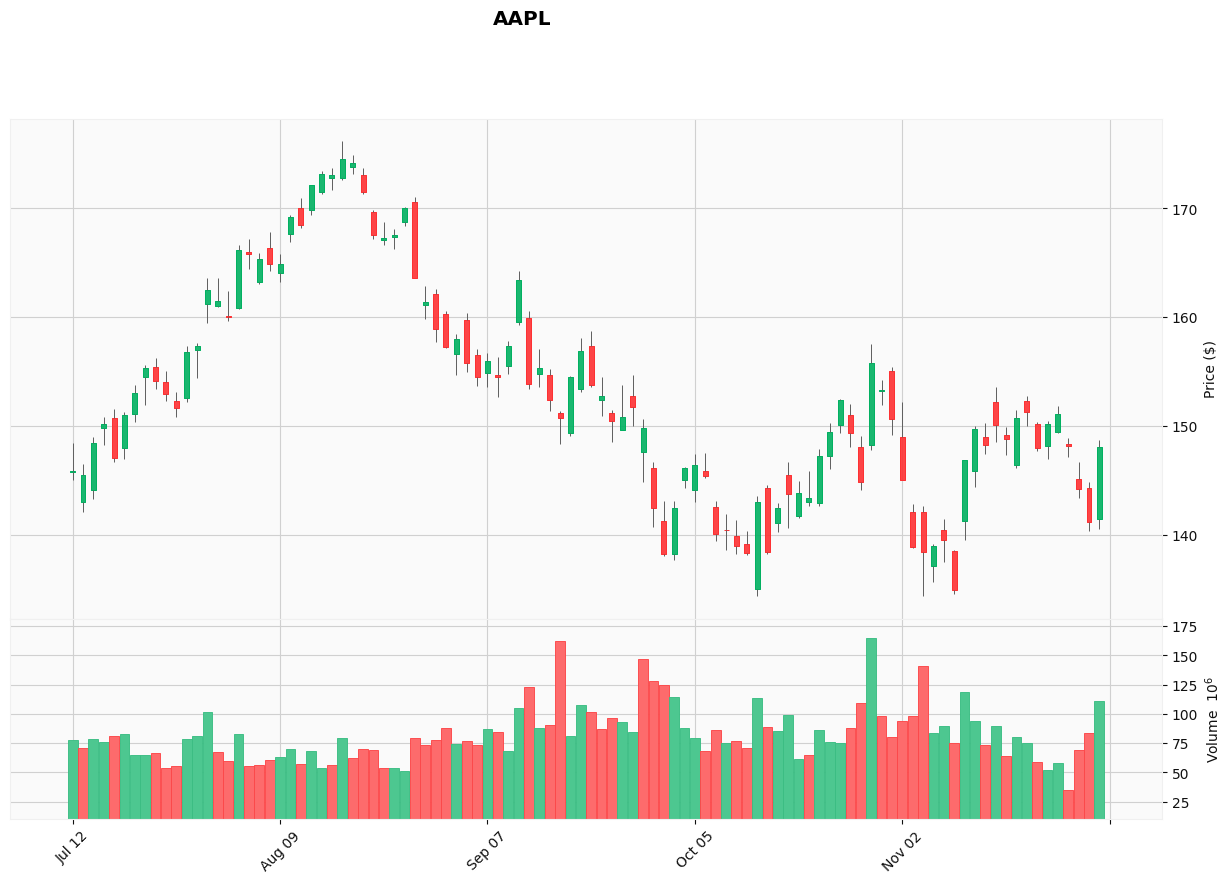

In [32]:
mpf.plot(aapl_df.tail(100), 
         type='candle', 
         title='AAPL', 
         ylabel='Price ($)',
         style='yahoo',
         volume=True, 
         figsize=(16,10));

In [212]:
class MovingAverageStrategy(bt.Strategy):

    params = {'period_fast':30, 'period_slow':200}
    params2 = (('period_fast',30), ('period_slow', 200))
    
    def __init__(self, short_period,long_period):
        self.close_data = self.data.close
        self.open_data = self.data.open
        self.fast_sma = bt.indicators.MovingAverageSimple(self.close_data,period=short_period)
        self.slow_sma = bt.indicators.MovingAverageSimple(self.close_data,period=long_period)
        #print(f'short period: {short_period}')
        
    # this function will be called after a next data point
    def next(self):
        #print("%s - %s" %(self.data.datetime.date(0),self.close_data[0]))
        if not self.position:
            # we can open long position
            if self.fast_sma[0] > self.slow_sma[0] and self.fast_sma[-1] < self.slow_sma[-1]:
                self.buy()
                #print('buy')
        else:
            if self.fast_sma[0] < self.slow_sma[0] and self.fast_sma[-1] > self.slow_sma[-1]:
                #print("sell reduce only (close)")
                self.close()
                
                

In [213]:
# Add data to Cerebro
cerebro = bt.Cerebro()

In [214]:
cerebro.adddata(data)

In [215]:
cerebro.addstrategy(MovingAverageStrategy,10,20)

0

In [216]:
cerebro.run()

In [217]:
btc_data = btfeeds.YahooFinanceCSVData(dataname="./data/btc.csv",fromdate=datetime(2019,1,1),todate=datetime(2022,1,1));

In [218]:
eth_df =pd.read_csv("./data/eth.csv", index_col='Date', parse_dates=True)
eth_df = eth_df.iloc[::-1]
eth_df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-11-29,476.675484,524.356285,427.233001,427.233001,1.497273e+09,4.593803e+10
2017-11-30,431.505862,465.240587,403.099585,447.889008,1.803252e+09,4.209423e+10
2017-12-01,446.687467,473.461463,428.973482,465.688648,1.071947e+09,4.307045e+10
2017-12-02,466.701873,477.328305,457.965814,465.195692,8.105988e+08,4.501313e+10
2017-12-03,465.176425,482.885385,453.236437,466.483835,6.057337e+08,4.525139e+10


In [219]:
# Add data to Cerebro via dataframe!
cerebro = bt.Cerebro()
eth_data = bt.feeds.PandasData(dataname=eth_df)
cerebro.adddata(eth_data)
cerebro.addstrategy(MovingAverageStrategy,20,200)

# add observers
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio,riskfreerate=0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

cerebro.broker.set_cash(3000000)

print("Initial capital: $%.2f" % cerebro.broker.getvalue())
model_results = cerebro.run()

Initial capital: $3000000.00


In [220]:
print(model_results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

0.4645448784383917


In [221]:
print(model_results[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.0007922686712898453), ('ravg', 4.3388207628140486e-07), ('rnorm', 0.00010934426087086303), ('rnorm100', 0.010934426087086302)])


In [222]:
print('Return: %.2f%%' % model_results[0].analyzers.returns.get_analysis()['rnorm100'])

Return: 0.01%


In [229]:
max_sharpe = -1
max_long = 0
max_short = 0

for long_period in range(200,100,-1):
    for short_period in range(1,99):
        cerebro = bt.Cerebro()
        eth_data = bt.feeds.PandasData(dataname=eth_df)
        cerebro.adddata(eth_data)
        cerebro.addstrategy(MovingAverageStrategy,short_period,long_period)

        # add observers
        cerebro.addobserver(bt.observers.Value)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio,riskfreerate=0)
        cerebro.addanalyzer(bt.analyzers.Returns)
        cerebro.addanalyzer(bt.analyzers.DrawDown)

        cerebro.broker.set_cash(100000)
        cerebro.broker.setcommission(0.01)

        model_results = cerebro.run()        
        current_sharpe_ratio_value = model_results[0].analyzers.sharperatio.get_analysis()['sharperatio']
        if current_sharpe_ratio_value:
            if float(current_sharpe_ratio_value) > max_sharpe:               
                max_sharpe = current_sharpe_ratio_value
                max_long = long_period
                max_short = short_period
                print(f'new max {max_sharpe} long: {max_long} short: {max_short}')
            
print('complete')
print(max_sharpe,max_long,max_short)
        
        

new max 0.37243073923623876 long: 200 short: 1
new max 0.38852791770573797 long: 200 short: 4
new max 0.3942746110892624 long: 200 short: 5
new max 0.4082605432014638 long: 200 short: 6
new max 0.4085682630548814 long: 200 short: 7
new max 0.4377397889580584 long: 200 short: 9
new max 0.46439863541279586 long: 200 short: 11
new max 0.4650220280616719 long: 186 short: 17
new max 0.4676779165348687 long: 182 short: 17
new max 0.46870081376444406 long: 181 short: 17
new max 0.4691589626871341 long: 180 short: 18
new max 0.46924323241536087 long: 179 short: 18
new max 0.46972607011984857 long: 177 short: 19
new max 0.46983199246256246 long: 176 short: 19
new max 0.4723451296084718 long: 174 short: 20
new max 0.4728822260472913 long: 169 short: 25
new max 0.47865475784041334 long: 157 short: 7
new max 0.479917631770333 long: 156 short: 8
new max 0.4803400548965767 long: 155 short: 8
new max 0.5008451197719894 long: 154 short: 6
new max 0.502660412960814 long: 153 short: 6


KeyboardInterrupt: 